In [175]:
import numpy as np
import random
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import time

In [176]:
def schaffer_function(mat_x_y):
    x = mat_x_y[:, 0]
    y = mat_x_y[:, 1]
    g = 0.5 + (np.power((np.sin( np.sqrt( np.power(x, 2) + np.power(y, 2)))), 2) - 0.5)/ \
        (1 + 0.001 * (np.power(x, 2) + np.power(y, 2)))
    return g

100%|██████████| 1000/1000 [00:00<00:00, 12895.08it/s]

--- 0.08033585548400879 seconds ---


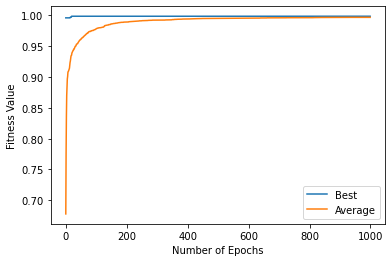

In [177]:
class DifferentialEvolutionAlgorithm():
    def __init__(self,
                 num_epochs:int,
                 pop_size:int,
                 chrom_length:int,
                 value_ranges:list,
                 mutation_rate:float,
                 fitness_func, # Function Type,
                 crossover_rate = 0.8,
                 seed=42,
                 eval_every=100,
                 verbose = 0,
                ):
        
        self.num_epochs = num_epochs
        self.pop_size = pop_size
        self.chrom_length = chrom_length
        self.value_ranges = np.array(value_ranges)
        self.mutation_rate = mutation_rate
        self.fitness_func = fitness_func
        self.seed = seed    
        self.crossover_rate = crossover_rate
        self.best_ind_list = np.zeros(self.num_epochs)
        self.avg_ind_list = np.zeros(self.num_epochs)
        self.eval_every = eval_every
        self.verbose = verbose

        np.random.seed(seed=seed)

    def init_pop(self):
        """
        Initializes a matrix with random values from an uniform distribution
        """
        self.x_g = np.random.rand(self.pop_size, self.chrom_length)
        # Denormalization process
        min_mat = self.value_ranges.T[0, :]
        max_mat = self.value_ranges.T[1,:]
        self.x_g = self.x_g * (max_mat - min_mat) + min_mat
        return

    def mutation(self):
        mutation_ind_indices_1 = np.random.randint(low=0, high=self.pop_size, size=self.pop_size)
        mutation_ind_indices_2 = np.random.randint(low=0, high=self.pop_size, size=self.pop_size)
        self.v_g = self.x_g + self.mutation_rate * \
              (self.x_g[mutation_ind_indices_1] - self.x_g[mutation_ind_indices_2])
        return
                
    def crossover(self):
        crossover_prob = np.random.rand(self.pop_size, self.chrom_length)
        aleat_index = np.random.randint(low=0, high=self.chrom_length, size=self.pop_size)
        #aleat_index_ohe = np.zeros((aleat_index.size, aleat_index.max() + 1))
        aleat_index_ohe = np.full((aleat_index.size, aleat_index.max() + 1), fill_value=False, dtype=bool)
        aleat_index_ohe[np.arange(aleat_index.size, dtype=int), aleat_index] = True
        self.u_g = self.x_g.copy()
        self.u_g[crossover_prob >= self.crossover_rate] = self.v_g[crossover_prob >= self.crossover_rate]
        self.u_g[aleat_index_ohe] = self.v_g[aleat_index_ohe]
        return

    def selection(self):
        self.fitness_x_g = self.fitness_func(self.x_g)
        self.fitness_u_g = self.fitness_func(self.u_g)
        replacement_indices = self.fitness_u_g > self.fitness_x_g
        self.x_g[replacement_indices] = self.u_g[replacement_indices]
        self.fitness_x_g[replacement_indices] = self.fitness_u_g[replacement_indices]
        return

    def callback(self):
        max_val = np.max(self.fitness_x_g)
        mean_val = np.mean(self.fitness_x_g)
        self.best_ind_list[self.curr_epoch] = max_val
        self.avg_ind_list[self.curr_epoch] = mean_val
        if (self.curr_epoch % self.eval_every == 0) and self.verbose != 0 :
            print(f"Epoch {self.curr_epoch}: Best: {max_val}, Average: {mean_val}")
    
    def fit(self):
        start_time = time.time()
        self.init_pop()
        for epoch in tqdm(range(self.num_epochs)):
            self.curr_epoch = epoch
            self.mutation()
            self.crossover()
            self.selection()
            self.callback()
        print("--- %s seconds ---" % (time.time() - start_time))
        return self.x_g

    def plot(self):
        plt.plot(self.best_ind_list, label="Best")
        plt.plot(self.avg_ind_list, label="Average")
        plt.xlabel("Number of Epochs")
        plt.ylabel("Fitness Value")
        plt.legend()
        plt.show()


de_alg = DifferentialEvolutionAlgorithm(
                                        num_epochs=1000,
                                        pop_size=100,
                                        chrom_length=2,
                                        value_ranges=[(-10,10), (-10,10)],
                                        mutation_rate=0.8,
                                        fitness_func=schaffer_function
                                        )
best_solutions = de_alg.fit()
de_alg.plot()

In [178]:
def schaffer_function_plot(x,y):
    g = 0.5 + (np.power((np.sin( np.sqrt( np.power(x, 2) + np.power(y, 2)))), 2) - 0.5)/ \
        (1 + 0.001 * (np.power(x, 2) + np.power(y, 2)))
    return g

In [179]:
x_data = best_solutions[:, 0]
y_data = best_solutions[:, 1]
z_data = schaffer_function_plot(x_data, y_data)

Text(0.5, 0, 'z')

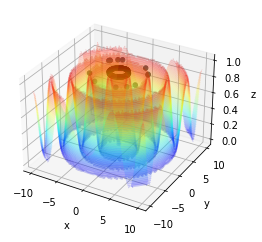

In [180]:
x = np.linspace(-10, 10, 50)
y = np.linspace(-10, 10, 50)

X, Y = np.meshgrid(x, y)
Z = schaffer_function_plot(X, Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='jet', alpha=0.2)
ax.scatter3D(x_data, y_data, z_data, c=z_data, cmap='binary', alpha=1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
